# Assignment 1: Implement Gaussian Mixture Model (GMM)

In this task, you are required to implement the GMM algorithm from scratch and apply it to the FIFA 23 Players Dataset and the EastWestAirlines Dataset for clustering. You should evaluate the performance of your clustering results using both qualitative and quantitative measures.

## Datasets
* **FIFA 23 Players Dataset**: This dataset contains detailed attributes of professional soccer players. The objective is to cluster players based on their skills and playing styles. Relevant features for clustering include:
  * Age
  * Overall rating (general skill level)
  * Potential (maximum projected skill level)
  * Value (market price in €)
  * Wage (weekly salary)
  * Shooting, Passing, Dribbling (technical abilities)
  * Defending, Physicality (defensive capabilities)

  You can download the dataset from Kaggle [FIFA 23 Dataset - Kaggle](https://www.kaggle.com/datasets/bryanb/fifa-player-stats-database?select=FIFA23_official_data.csv)

* **EastWestAirlines Dataset**: This dataset contains information about airline customers and their behaviors. You should preprocess the dataset as necessary before applying the clustering algorithm.

## Tasks

1. Implement the Gaussian Mixture Model algorithm from scratch. Do not use libraries like scikit-learn's GMM implementation for this part.
2. Fit the GMM to both datasets (FIFA 23 Players and EastWestAirlines) and perform clustering.
3. Evaluate your clustering results using the following methods:
   * **Rand Index**: Calculate the Rand Index to compare your clustering results against meaningful labels (e.g., player positions). Read more about the Rand Index here: [Rand Index - Wikipedia](https://en.wikipedia.org/wiki/Rand_index).
   * **Qualitative Evaluation**: For both datasets, visualize and describe the resulting clusters (e.g., scatter plots, pair plots, or other visualizations that highlight the formed groups). For visualizations in Python, you may refer to this guide: [Seaborn Visualization Library](https://seaborn.pydata.org/).

## Hints and Useful Links

* For a detailed explanation on how Gaussian Mixture Models work and how to implement them, see this tutorial: [Gaussian Mixture Model - scikit-learn documentation](https://scikit-learn.org/stable/modules/mixture.html).
* To understand the mathematical background and principles behind GMM, this reference may help: [Mixture Model - Wikipedia](https://en.wikipedia.org/wiki/Mixture_model).

## Solution 

> **Note** </br>
> The solution will be described in spanish.

### 1. Librerias y configuraciones previas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.metrics import rand_score
from sklearn.preprocessing import LabelEncoder

### 2. Funciones

A continuación se colocan las funciones suministradas por el profesor.

In [82]:
# Function to generate a positive definite covariance matrix
def generate_positive_definite_matrix(d):
    A = np.random.randn(d, d)
    return np.dot(A, A.T) + np.eye(d) * epsilon  # Add identity for stability

# Ensure covariance matrix is positive definite
def ensure_positive_definite(Sigma):
    return Sigma + np.eye(Sigma.shape[0]) * epsilon

# Expectation Step (E-step)
def expectation_step(X, mu, Sigma, pi):
    """ Compute responsibilities (γ) given current parameters. """
    gamma = np.zeros((n, K))
    for k in range(K):
        try:
            gamma[:, k] = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=ensure_positive_definite(Sigma[k]))
        except np.linalg.LinAlgError:
            print(f"Warning: Fixing singular covariance matrix for cluster {k}")
            Sigma[k] = ensure_positive_definite(Sigma[k])
            gamma[:, k] = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k])

    gamma += epsilon  # Prevents division by zero
    gamma /= gamma.sum(axis=1, keepdims=True)  # Normalize
    return gamma

# Maximization Step (M-step)
def maximization_step(X, gamma):
    """ Update parameters based on responsibilities. """
    Nk = gamma.sum(axis=0)  # Effective cluster size
    pi_new = Nk / n  # Update mixing coefficients
    mu_new = np.dot(gamma.T, X) / Nk[:, np.newaxis]  # Update means

    Sigma_new = np.zeros((K, d, d))
    for k in range(K):
        X_centered = X - mu_new[k]
        Sigma_new[k] = np.dot(gamma[:, k] * X_centered.T, X_centered) / Nk[k]
        Sigma_new[k] = ensure_positive_definite(Sigma_new[k])  # Ensure positive definiteness

    return pi_new, mu_new, Sigma_new

# Compute Log-Likelihood
def compute_log_likelihood(X, pi, mu, Sigma):
    """ Compute the Log-Likelihood to monitor convergence. """
    log_likelihood = 0
    for k in range(K):
        try:
            prob = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=ensure_positive_definite(Sigma[k]))
            prob += epsilon  # Prevents log(0)
            log_likelihood += np.sum(np.log(prob))
        except np.linalg.LinAlgError:
            print(f"Warning: Fixing covariance matrix for cluster {k}")
            Sigma[k] = ensure_positive_definite(Sigma[k])
            prob = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k]) + epsilon
            log_likelihood += np.sum(np.log(prob))

    return log_likelihood

### 3. Carga del dataset

In [83]:
# Se carga el dataset
csv_file = 'FIFA23_official_data.csv'
df_players = pd.read_csv(csv_file)
df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17660 entries, 0 to 17659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        17660 non-null  int64  
 1   Name                      17660 non-null  object 
 2   Age                       17660 non-null  int64  
 3   Photo                     17660 non-null  object 
 4   Nationality               17660 non-null  object 
 5   Flag                      17660 non-null  object 
 6   Overall                   17660 non-null  int64  
 7   Potential                 17660 non-null  int64  
 8   Club                      17449 non-null  object 
 9   Club Logo                 17660 non-null  object 
 10  Value                     17660 non-null  object 
 11  Wage                      17660 non-null  object 
 12  Special                   17660 non-null  int64  
 13  Preferred Foot            17660 non-null  object 
 14  Intern

Se renombran las columnas

In [84]:
df_players.columns = df_players.columns.str.replace(' ', '_')
df_players.columns = df_players.columns.str.lower()
df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17660 entries, 0 to 17659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        17660 non-null  int64  
 1   name                      17660 non-null  object 
 2   age                       17660 non-null  int64  
 3   photo                     17660 non-null  object 
 4   nationality               17660 non-null  object 
 5   flag                      17660 non-null  object 
 6   overall                   17660 non-null  int64  
 7   potential                 17660 non-null  int64  
 8   club                      17449 non-null  object 
 9   club_logo                 17660 non-null  object 
 10  value                     17660 non-null  object 
 11  wage                      17660 non-null  object 
 12  special                   17660 non-null  int64  
 13  preferred_foot            17660 non-null  object 
 14  intern

Se obtienen las columnas categoricas y numericas y se inspeccionan por separado

In [85]:
# Columnas categoricas
player_catCols = df_players.select_dtypes(include = ["object", 'category']).columns.tolist()
df_players[player_catCols].head(2)

,name,photo,nationality,flag,club,club_logo,value,wage,preferred_foot,work_rate,body_type,real_face,position,joined,loaned_from,contract_valid_until,height,weight,release_clause,best_overall_rating
0,L. Goretzka,https://cdn.sofifa.net/players/209/658/23_60.png,Germany,https://cdn.sofifa.net/flags/de.png,FC Bayern München,https://cdn.sofifa.net/teams/21/30.png,€91M,€115K,Right,High/ Medium,Unique,Yes,"<span class=""pos pos28"">SUB","Jul 1, 2018",NaN,2026,189cm,82kg,€157M,NaN
1,Bruno Fernandes,https://cdn.sofifa.net/players/212/198/23_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,Manchester United,https://cdn.sofifa.net/teams/11/30.png,€78.5M,€190K,Right,High/ High,Unique,Yes,"<span class=""pos pos15"">LCM","Jan 30, 2020",NaN,2026,179cm,69kg,€155M,NaN


Si observamos, hay varias columnas que no son de utilidad, por ejemplo **photo** y **body_type** por citar algunas. Sin embargo, vemos que otras como **value** y **wage** tienen que ver con dinero y consideramos que son datos relevantes.

A continuación inspeccionamos las variables numericas:

In [86]:
# Columnas numericas
player_numCols = df_players.select_dtypes(include = ['float64','int32','int64']).columns.tolist()
df_players[player_numCols].head(2)

,id,age,overall,potential,special,international_reputation,weak_foot,skill_moves,kit_number
0,209658,27,87,88,2312,4.0,4.0,3.0,8.0
1,212198,27,86,87,2305,3.0,3.0,4.0,8.0


De las variables númericas vistas que no aportan a nuestro conceptos son: **id** asi que de entrada la quitamos.

In [87]:
player_numCols.remove('id')

Veamos un poco mas de información estadistica de los datos numericos restantes:

In [88]:
df_players[player_numCols].describe()

,age,overall,potential,special,international_reputation,weak_foot,skill_moves,kit_number
count,17660.000000,17660.000000,17660.000000,17660.000000,17660.000000,17660.000000,17660.000000,17625.000000
mean,23.127746,63.369592,70.981200,1537.915855,1.106285,2.900340,2.297169,25.037957
std,4.639821,8.036268,6.529836,285.893809,0.407021,0.663523,0.754264,19.154116
min,15.000000,43.000000,42.000000,749.000000,1.000000,1.000000,1.000000,1.000000
25%,20.000000,58.000000,67.000000,1387.000000,1.000000,3.000000,2.000000,11.000000
50%,22.000000,63.000000,71.000000,1548.000000,1.000000,3.000000,2.000000,22.000000
75%,26.000000,69.000000,75.000000,1727.000000,1.000000,3.000000,3.000000,32.000000
max,54.000000,91.000000,95.000000,2312.000000,5.000000,5.000000,5.000000,99.000000


Para visualizar la distribución de los datos numericos, se realiza un pairplot

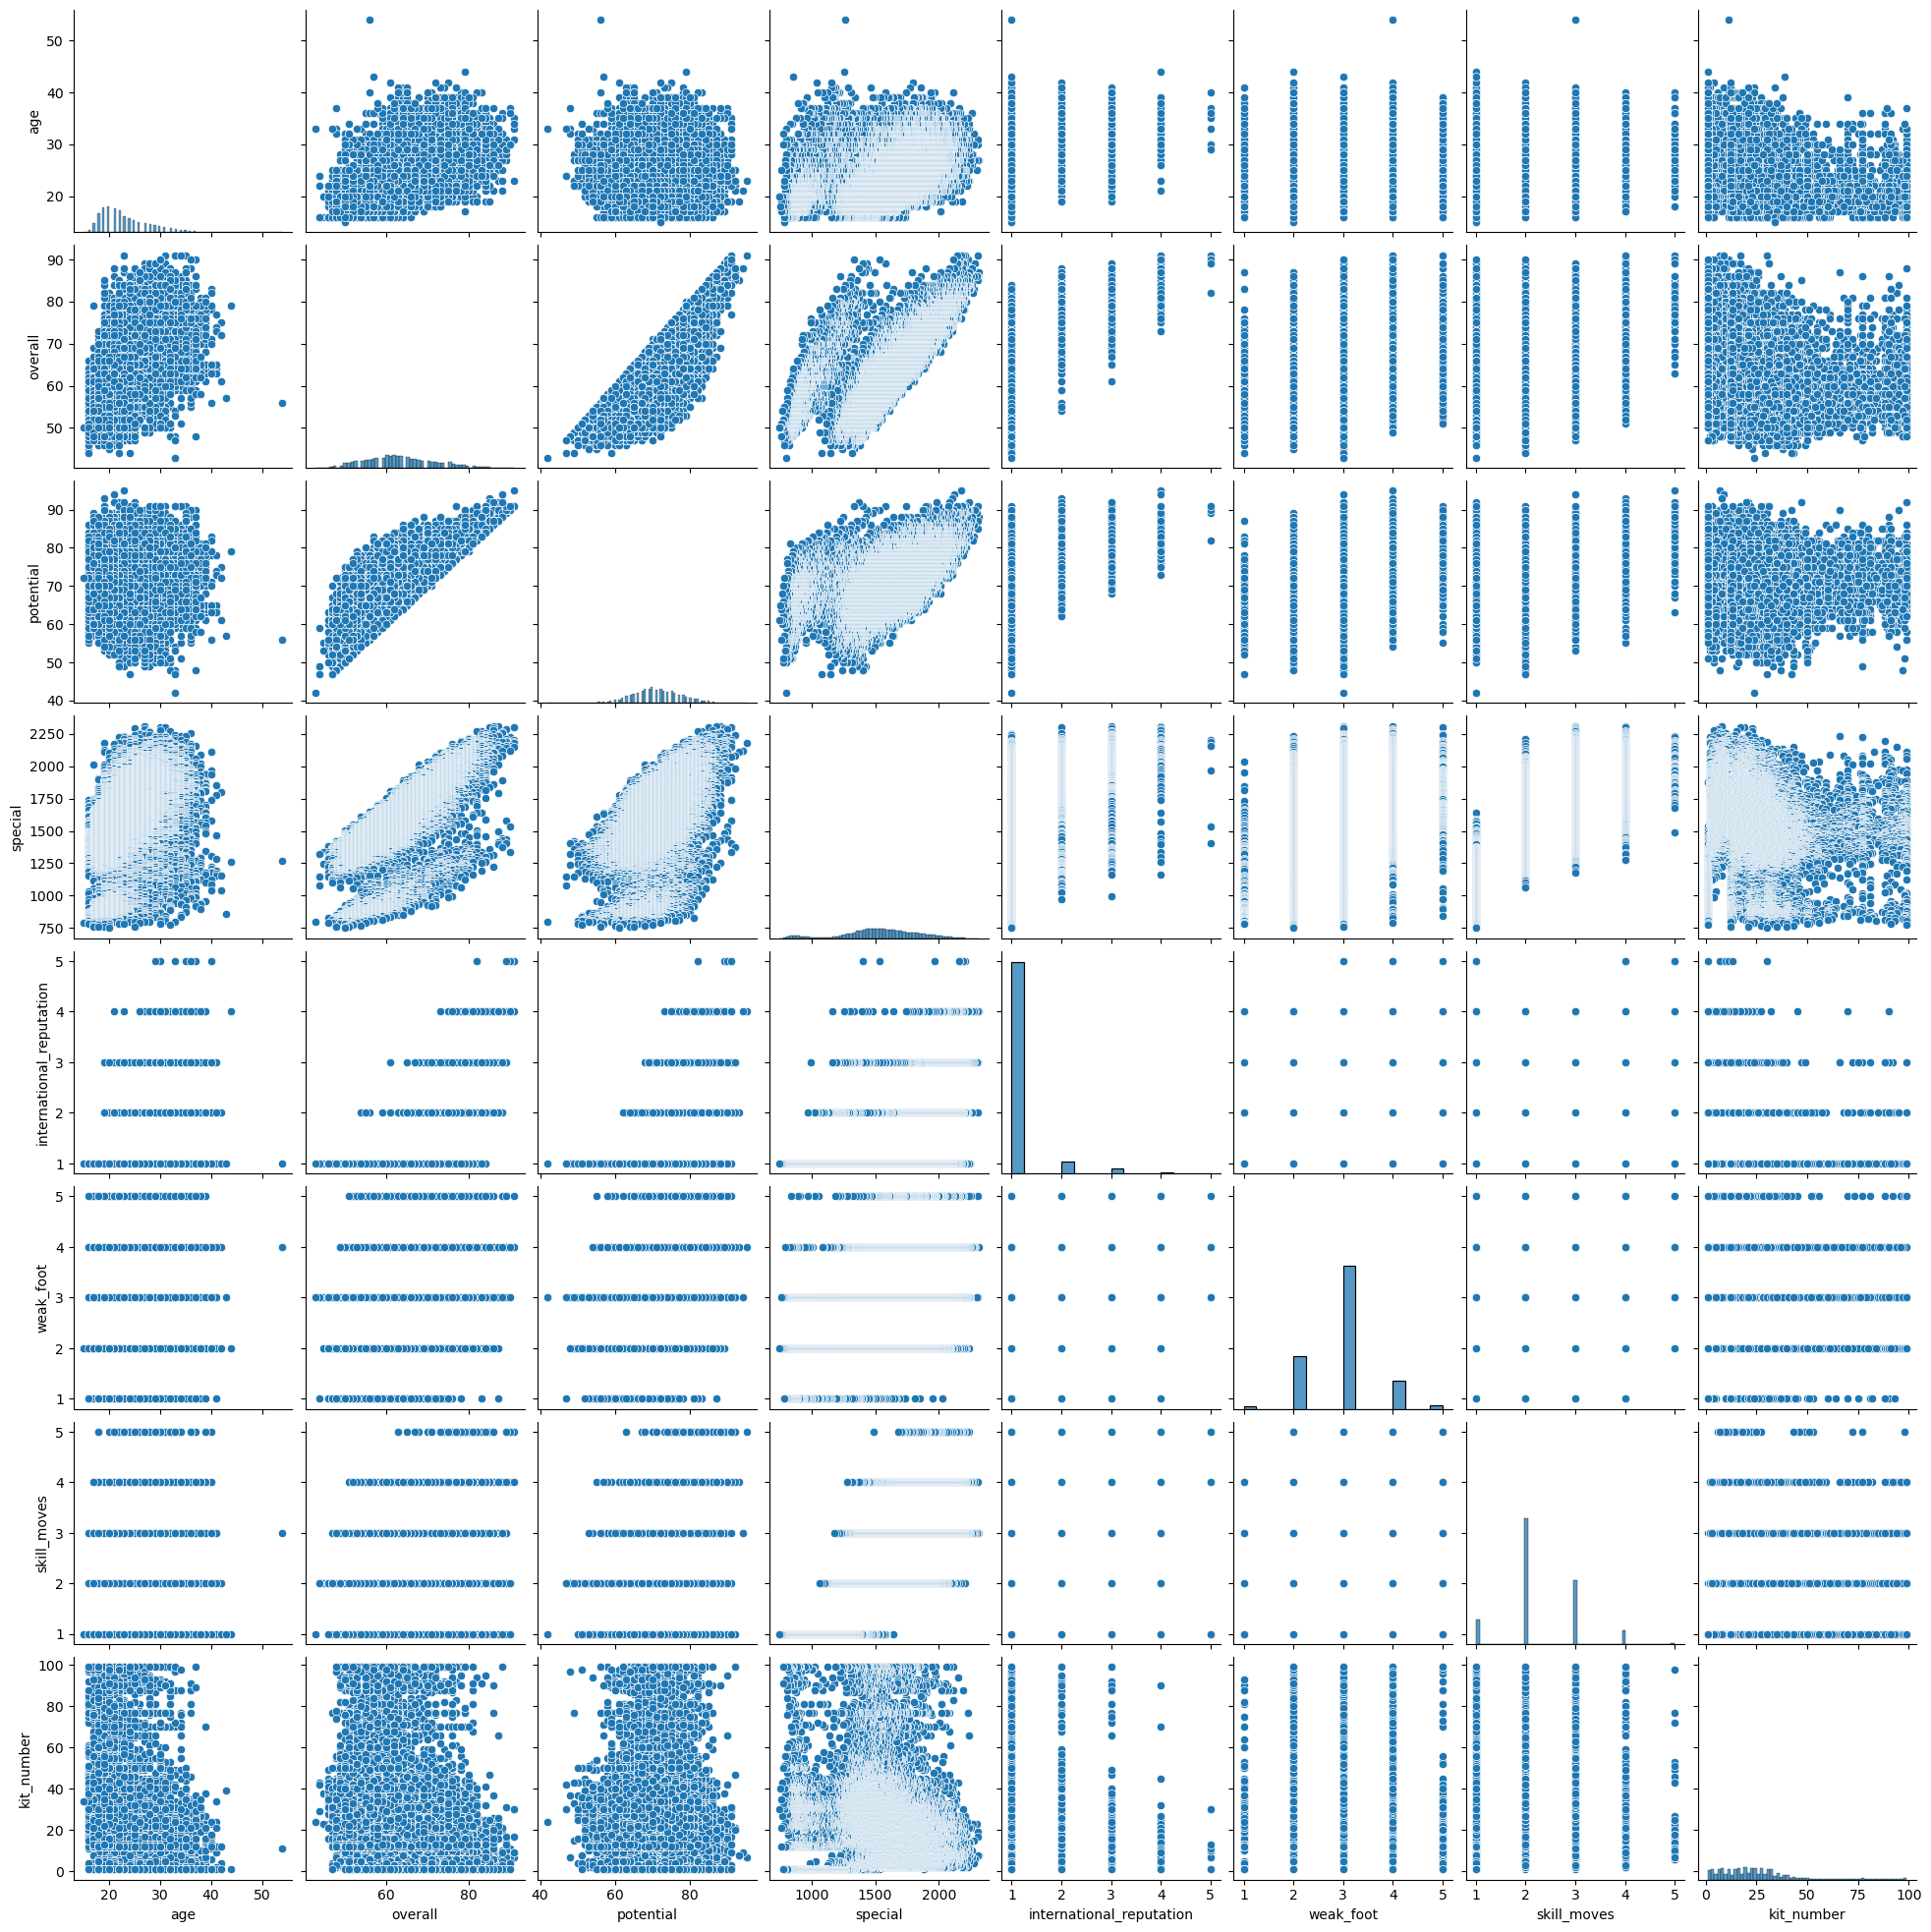

In [89]:
sns.pairplot(df_players[player_numCols])
plt.show()

Al observar la grafica anterior, vamos a dejar para las columnas numericas de interes aquellas que no tienen una distribución tipo campana, para el caso: **international_reputation**, **weak_foot**, **skill_moves** y **kit_number**

In [90]:
player_numCols.remove('international_reputation')
player_numCols.remove('weak_foot')
player_numCols.remove('skill_moves')
player_numCols.remove('kit_number')
player_numCols

['age', 'overall', 'potential', 'special']

Vamos a definir un dataframe **df** de trabajo tomando inicialmente las columnas anteriores:

In [92]:
features_selected = player_numCols + ['value','wage']
#features_selected
df = df_players[features_selected]
df.head(2)

,age,overall,potential,special,value,wage
0,27,87,88,2312,€91M,€115K
1,27,86,87,2305,€78.5M,€190K


Como las dos ultimas son categoricas las vamos a volver numericas:

In [93]:
def convert_mk_to_numeric(value):
    if isinstance(value, str):  # Asegurar que el valor es una cadena
        if 'M' in value:
            return float(value.replace('M', '')) * 1e6
        elif 'K' in value:
            return float(value.replace('K', '')) * 1e3
        else:
            return float(value)
    return value  # Si no es string, devolver el valor original

In [94]:
# Columna Value
df['value'] = df['value'].str[1:]
df['value']= df['value'].apply(convert_mk_to_numeric)

# Columna Wage
df['wage'] = df['wage'].str[1:]
df['wage'] = df['wage'].apply(convert_mk_to_numeric)

# Inspeccion del frame
df.head(2)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18936\3599422573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].str[1:]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18936\3599422573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value']= df['value'].apply(convert_mk_to_numeric)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18936\3599422573.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

,age,overall,potential,special,value,wage
0,27,87,88,2312,91000000.0,115000.0
1,27,86,87,2305,78500000.0,190000.0


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17660 entries, 0 to 17659
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        17660 non-null  int64  
 1   overall    17660 non-null  int64  
 2   potential  17660 non-null  int64  
 3   special    17660 non-null  int64  
 4   value      17660 non-null  float64
 5   wage       17660 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 827.9 KB


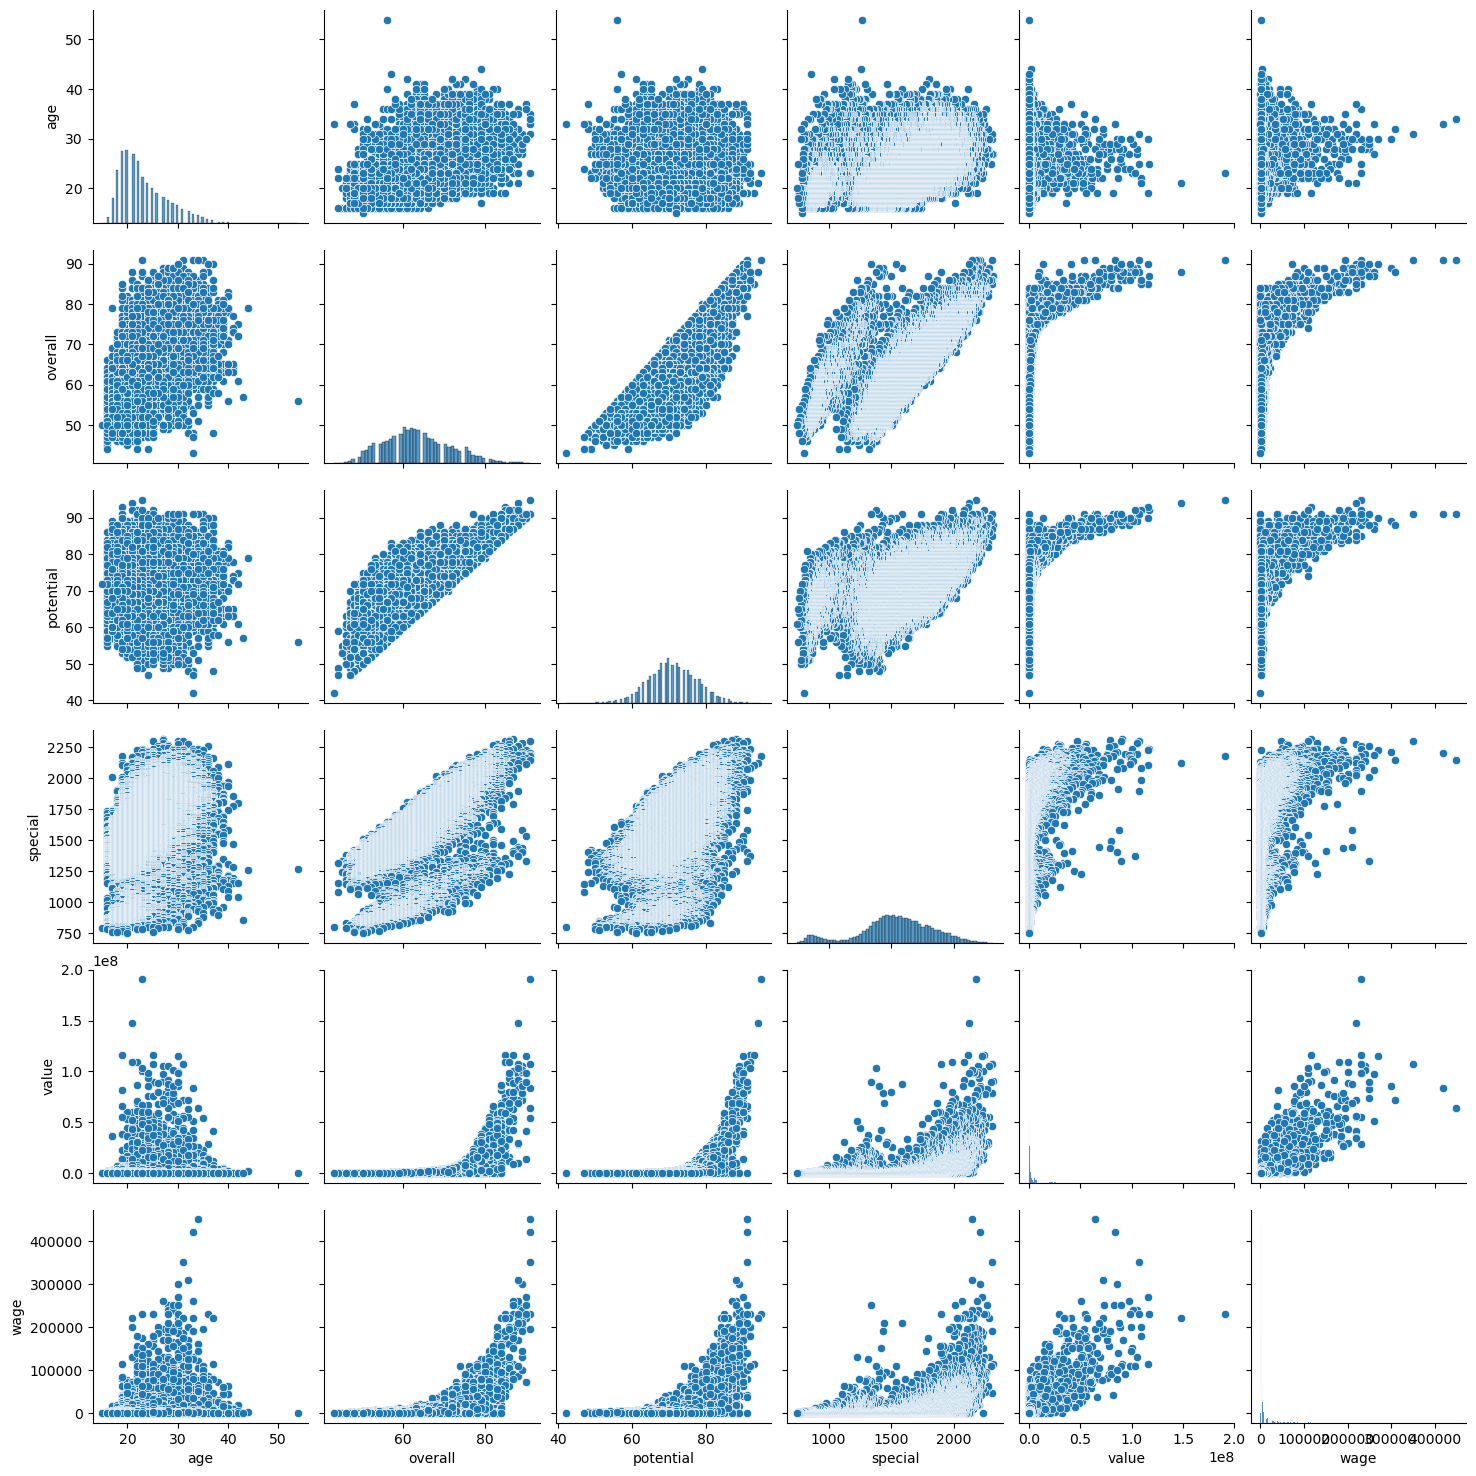

In [98]:
sns.pairplot(df[features_selected])
plt.show()

## Algoritmos empleados

### GMM 

#### Fifa 23 dataset

In [99]:
# Set random seed for reproducibility
np.random.seed(42)

In [101]:
X = df.values
X

array([[2.700e+01, 8.700e+01, 8.800e+01, 2.312e+03, 9.100e+07, 1.150e+05],
       [2.700e+01, 8.600e+01, 8.700e+01, 2.305e+03, 7.850e+07, 1.900e+05],
       [3.000e+01, 8.500e+01, 8.500e+01, 2.303e+03, 4.650e+07, 4.600e+04],
       ...,
       [2.500e+01, 5.100e+01, 5.600e+01, 7.590e+02, 7.000e+04, 2.000e+03],
       [1.800e+01, 5.000e+01, 6.500e+01, 7.580e+02, 9.000e+04, 5.000e+02],
       [2.000e+01, 5.000e+01, 6.100e+01, 7.490e+02, 9.000e+04, 5.000e+02]])

In [116]:
# Initialize parameters
K = 6  # Number of clusters
n, d = X.shape
epsilon = 1e-6  # Small value to prevent log(0)

# Normalize data
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)

# Mixing coefficients (initial uniform distribution)
pi = np.ones(K) / K  

In [117]:
# Initialize means using random samples from data
random_indices = np.random.choice(n, K, replace=False)
mu = X_norm[random_indices, :]
# Initialize covariance matrices
Sigma = np.array([generate_positive_definite_matrix(d) for _ in range(K)])

Aplicación del algoritmo EM

Iteration 1, Log-Likelihood: -861048.1203
Iteration 2, Log-Likelihood: -912145.3888
Iteration 3, Log-Likelihood: -1017438.7214
Iteration 4, Log-Likelihood: -1093250.8335
Iteration 5, Log-Likelihood: -1130993.3453
Iteration 6, Log-Likelihood: -1152662.5651
Iteration 7, Log-Likelihood: -1172898.9557
Iteration 8, Log-Likelihood: -1194769.4037
Iteration 9, Log-Likelihood: -1215418.6599
Iteration 10, Log-Likelihood: -1227783.3588
Iteration 11, Log-Likelihood: -1233869.5282
Iteration 12, Log-Likelihood: -1236764.5308
Iteration 13, Log-Likelihood: -1238059.0963
Iteration 14, Log-Likelihood: -1238616.7066
Iteration 15, Log-Likelihood: -1238881.8375
Iteration 16, Log-Likelihood: -1239023.4846
Iteration 17, Log-Likelihood: -1239109.9532
Iteration 18, Log-Likelihood: -1239172.2573
Iteration 19, Log-Likelihood: -1239226.7979
Iteration 20, Log-Likelihood: -1239282.7113
Iteration 21, Log-Likelihood: -1239343.9672
Iteration 22, Log-Likelihood: -1239410.1319
Iteration 23, Log-Likelihood: -1239477.5104

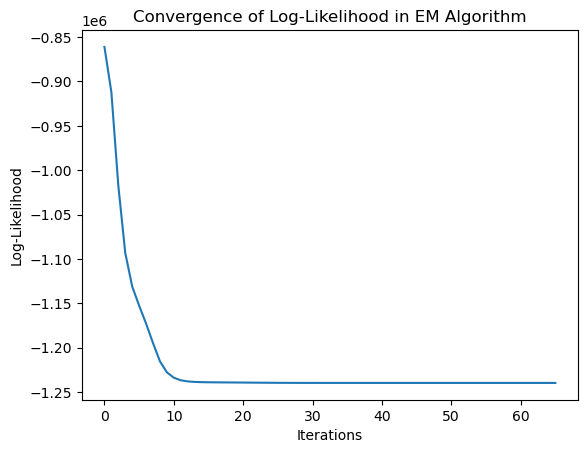

In [118]:
# EM Algorithm for GMM
max_iters = 200  # Maximum iterations
tol = 1e-4  # Convergence threshold
log_likelihoods = []
prev_log_likelihood = -np.inf  # Initialize with a very low value

for i in range(max_iters):
    gamma = expectation_step(X_norm, mu, Sigma, pi)
    pi, mu, Sigma = maximization_step(X_norm, gamma)

    # Compute log-likelihood
    log_likelihood = compute_log_likelihood(X_norm, pi, mu, Sigma)
    log_likelihoods.append(log_likelihood)

    print(f"Iteration {i+1}, Log-Likelihood: {log_likelihood:.4f}")

    # Check for convergence
    if np.abs(log_likelihood - prev_log_likelihood) < tol:
        print(f"Converged at iteration {i+1}.")
        break
    prev_log_likelihood = log_likelihood

# Plot log-likelihood evolution
plt.plot(log_likelihoods)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.title('Convergence of Log-Likelihood in EM Algorithm')
plt.show()

# Assign cluster labels based on maximum responsibility
Z = np.argmax(gamma, axis=1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18936\3116023010.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = Z


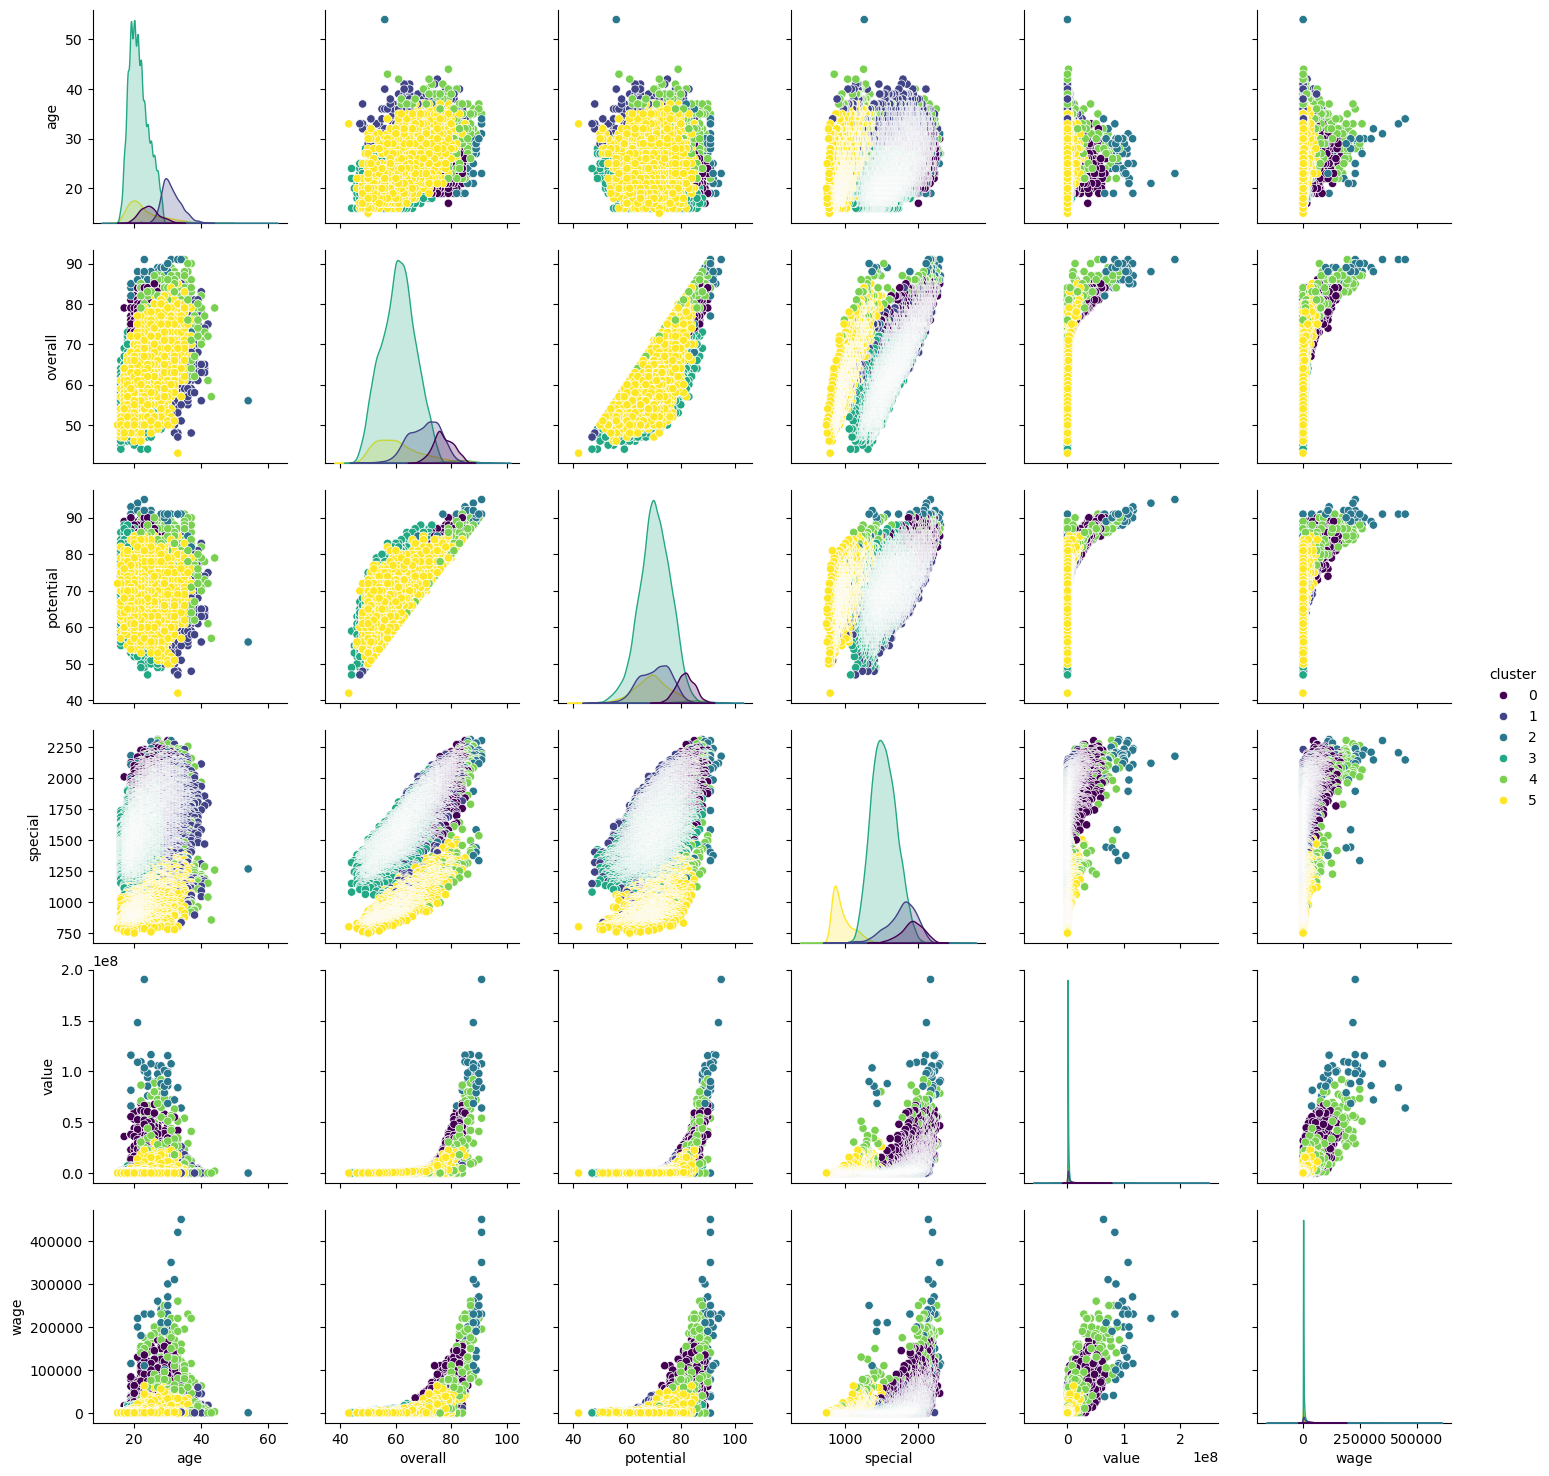

In [119]:
# Assuming 'Z' contains the cluster labels obtained from the GMM algorithm
# and 'df' is your DataFrame with the relevant features
# Create a new column in the DataFrame to store the cluster labels
df['cluster'] = Z

sns.pairplot(df, hue='cluster', palette = 'viridis')
plt.show()

In [120]:
df.head(5)

,age,overall,potential,special,value,wage,cluster
0,27,87,88,2312,91000000.0,115000.0,2
1,27,86,87,2305,78500000.0,190000.0,4
2,30,85,85,2303,46500000.0,46000.0,0
3,31,91,91,2303,107500000.0,350000.0,2
4,25,86,89,2296,89500000.0,110000.0,2


In [121]:
df_players['cluster'] = df['cluster']
df_players.head()

,id,name,age,photo,nationality,flag,overall,potential,club,club_logo,...,position,joined,loaned_from,contract_valid_until,height,weight,release_clause,kit_number,best_overall_rating,cluster
0,209658,L. Goretzka,27,https://cdn.sofifa.net/players/209/658/23_60.png,Germany,https://cdn.sofifa.net/flags/de.png,87,88,FC Bayern München,https://cdn.sofifa.net/teams/21/30.png,...,"<span class=""pos pos28"">SUB","Jul 1, 2018",NaN,2026,189cm,82kg,€157M,8.0,NaN,2
1,212198,Bruno Fernandes,27,https://cdn.sofifa.net/players/212/198/23_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,86,87,Manchester United,https://cdn.sofifa.net/teams/11/30.png,...,"<span class=""pos pos15"">LCM","Jan 30, 2020",NaN,2026,179cm,69kg,€155M,8.0,NaN,4
2,224334,M. Acuña,30,https://cdn.sofifa.net/players/224/334/23_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,85,85,Sevilla FC,https://cdn.sofifa.net/teams/481/30.png,...,"<span class=""pos pos7"">LB","Sep 14, 2020",NaN,2024,172cm,69kg,€97.7M,19.0,NaN,0
3,192985,K. De Bruyne,31,https://cdn.sofifa.net/players/192/985/23_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,91,91,Manchester City,https://cdn.sofifa.net/teams/10/30.png,...,"<span class=""pos pos13"">RCM","Aug 30, 2015",NaN,2025,181cm,70kg,€198.9M,17.0,NaN,2
4,224232,N. Barella,25,https://cdn.sofifa.net/players/224/232/23_60.png,Italy,https://cdn.sofifa.net/flags/it.png,86,89,Inter,https://cdn.sofifa.net/teams/44/30.png,...,"<span class=""pos pos13"">RCM","Sep 1, 2020",NaN,2026,172cm,68kg,€154.4M,23.0,NaN,2


In [123]:
df_players['cluster'].value_counts()

cluster
3    12129
1     2491
5     1768
0     1082
4      146
2       44
Name: count, dtype: int64

In [132]:
cluster_1 = df_players[df_players['cluster'] == 1]
cluster_2 = df_players[df_players['cluster'] == 2]
cluster_3 = df_players[df_players['cluster'] == 3]
cluster_4 = df_players[df_players['cluster'] == 4]
cluster_5 = df_players[df_players['cluster'] == 5]
cluster_6 = df_players[df_players['cluster'] == 6]

In [142]:
unique_1 = cluster_1['age'].unique()
print(unique_1)
print()
unique_2 = cluster_2['age'].unique()
print(unique_2)
print()
unique_3 = cluster_3['age'].unique()
print(unique_3)
print()
unique_4 = cluster_4['age'].unique()
print(unique_4)
print()
unique_5 = cluster_5['age'].unique()
print(unique_5)
print()
unique_6 = cluster_6['age'].unique()
print(unique_6)

[32 35 30 34 33 29 36 28 31 27 40 22 26 37 38 25 39 41 42 20 23 21]

[27 31 25 23 30 33 24 28 19 34 32 29 21 22 36 37 54]

[25 24 26 23 28 22 27 21 20 19 18 29 17 16]

[27 30 28 36 33 31 34 32 35 29 23 25 37 22 26 38 24 40 39 41 44 42 43]

[28 33 26 32 27 31 35 29 36 34 30 25 22 24 37 20 23 21 19 18 17 16 15]

[]


### Kmeans